In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
plt.ion()

import sklearn.svm
import sklearn.tree

## We provide you 3 datasets to play with :
- MNIST in small resolution (8x8 pixels images)
- MNIST, classic: 28x28 resolution 
- Fashion_MNIST, 28x28 resolution

In [2]:
## data set 1 ##
K=10
import sklearn.datasets
X,y = sklearn.datasets.load_digits(n_class=K, return_X_y=True)
linearPictureLength = 8 # Global variable
ratio_train = 0.6 # we may reduce this number when using mnist70 (70 000 images !)
ratio_valid = 0.3 # same here

### In your shell, do this to get the data:
`wget https://gitlab.inria.fr/flandes/data-for-teaching/-/raw/master/mnist70.npz?inline=false`

In [3]:
## data set 2 ##
LoadObject = np.load("mnist70.npz")
linearPictureLength = 28
X = LoadObject['X']
y = LoadObject['y']
del LoadObject
ratio_train = 0.005
ratio_valid = 0.1
print(X.shape)

(70000, 784)


### In your shell, do this to get the data:
`wget https://gitlab.inria.fr/flandes/data-for-teaching/-/raw/master/fashion-mnist-reshaped.npz?inline=false`

In [13]:
## data set 3 ##
LoadObject = np.load("fashion-mnist-reshaped.npz")
linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
Xtest = LoadObject['test_images']
ytest = LoadObject['test_labels']
X     = np.array(X    , dtype=float) ## change the type, which is iniitially unsigned-int (uint)
Xtest = np.array(Xtest, dtype=float)
del LoadObject
ratio_train = 0.05
ratio_valid = 0.1
print(X.shape)

(60000, 784)


In [16]:
X[1]

array([  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,  41.,
       188., 103.,  54.,  48.,  43.,  87., 168., 133.,  16.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,  49., 136., 219., 216., 228., 236., 255., 255., 255.,
       255., 217., 215., 254., 231., 160.,  45.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  14., 176., 222., 224., 212.,
       203., 198., 196., 200., 215., 204., 202., 201., 201., 201., 209.,
       218., 224., 164.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 188., 219., 200., 198., 202., 198., 199., 199., 201., 196.,
       198., 198., 200., 200., 200., 200., 201., 200., 225.,  41.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  51., 219., 199., 203., 203.,
       212., 238., 248., 250., 245., 249., 246., 247., 252., 248., 235.,
       207., 203., 203., 222., 140.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 116., 226., 206., 204., 207., 204., 10

## We load the data and split it into train, validation and test set.

It's good to do this early, and remember to only use the train set for most operations.

The validation set may be used to find the best hyper-parameters

The test can be used.. only **once** ! Then it "expires", like old food is wasted after a couple of weeks.

In [5]:
def load_subSets(X, ratio_train, ratio_valid):
    ratio_test = 1 - ratio_train - ratio_valid #
    assert(ratio_test>0)
    Ntot   = X.shape[0]
    Ntrain = int(ratio_train*Ntot)
    Nvalid = int(ratio_valid*Ntot)
    Ntest  = Ntot - Ntrain - Nvalid
    X_train = X[0: Ntrain].copy()
    y_train = y[0: Ntrain].copy()
    X_valid = X[Ntrain:Ntrain+Nvalid].copy() #  X[-Ntest:] also does the same
    y_valid = y[Ntrain:Ntrain+Nvalid].copy() # 
    X_test  = X[-Ntest:].copy()
    y_test  = y[-Ntest:].copy()
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [6]:
## actually load the data into separate arrays
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)
X_train.shape

(3000, 784)

### Note  

You can also use `sklearn.model_selection.train_test_split`

# First part: getting a sense of what PCA does

## 1.1 Normalization

- take a quick look at the data: what does it look like ? What are the min and max values ?
- normalize the input so all values of the training set are between 0 and 1. Perform the appropriate operation on the val and test sets so that they are consistent with this pre-processing operation.

In [20]:
X_train[n].reshape(linearPictureLength, linearPictureLength)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,  13.,  73.,   0.,   0.,   1.,   4.,   0.,
          0.,   0.,   0.,   1.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   3.,   0.,  36., 136., 127.,  62.,  54.,   0.,   0.,   0.,
          1.,   3.,   4.,   0.,   0.,   3.],
       [  0.,   0.,   0.,   0.,   0

9


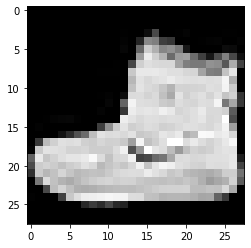

In [18]:
n=0
plt.imshow(X_train[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
print(y[n])

## Normalization: here we choose to simply perform min-max normalization

What are the other choices ?

- perform a simple normalization, setting the min vlaue to 0 and max value to 1

# Remark !

We divide each sub-part of the data by the **same** value, not each by its max !

This is important: in the spirit of pre-processing and train/val/test split, you must use only the training data to pre-process (all) the data, including the validation and test sets.

The pipeline is not supposed to know in advance hte maximum value of the validation or test sets !


## 1.2 Your first PCA compression (+decompression)


We want to see what typical PCA does on an image.
- using the method `sklearn.decomposition.PCA` from the `scikit-learn` library, compress the training set (i.e. perform its PCA). Then, decompress this compressed version, and compare an image before and after its transformation.  For this, you will need to :
    - define an instance of the class `sklearn.decomposition.PCA`, that we may call "model" or "preProcessing"
    - use the methods `fit`, `transofrm` and `inverse_transform`
    - use the plot funciton  `plot_before_vs_after_compression` that we provide below
    - remember to make copies, not in-place transformation !
    - to start, you can use an explained variance ratio of 95%
- compare a couple of images (pick random images, just to take a look not just at 1 case)
- compute the Squared Error (squared difference between original and compresse+decompressed images) for a single image.
- compute the Mean Squared Error (same thing but averaged on all training set images).
- by browsing the methods of `sklearn.decomposition.PCA`, find a way to display the *explained variance ratio*, for all possible values of the number of PCA components to be kept. Plot it on a graph.
- display the before/after image comparison for a low number of components, e.g. 30

In [ ]:
def plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y):
    plt.figure()
    plt.imshow(X_train[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
    plt.title("this is supposed to look like a "+str(y[n])+ " before compression")
    plt.savefig(str(n)+"_beforeCompression.png")

    plt.figure()
    plt.imshow(X_train_Transf_decompressed[n].reshape(linearPictureLength, linearPictureLength) , cm.gray)
    plt.title("this is supposed to look like a "+str(y[n])+ " after compression+decompression")
    plt.savefig(str(n)+"_afterCompression.png")

    print("The MSE for this image is ", np.mean( (X_train[n]- X_train_Transf_decompressed[n])**2) )

In [ ]:
### 1st attempt at PCA with an explained_variance ratio set to 0.95
varianceExplained=0.95

# TODO # 

## X_train_Transf_decompressed = ??

In [ ]:
## displaying the total variance explained at various values of nComp


In [ ]:
n=2
plot_before_vs_after_compression(n, X_train, X_train_Transf_decompressed, y)

In [ ]:
# varianceExplained=30 # 30 compnents


# Second part: make your own PCA !

Now we want to really make sure we understand how PCA is, or can be done.

## 2.1 Theory

- Check out the lecture notes and make sure you understood the maths


## 2.2 PCA 

Compute the PCA of the training set, using:
- `np.mean(..., axis=...)` to compute the average of an array along one of its axes
- `np.outer` computes the outer product of two vectors (you can also cheat and use `np.cov`... but it's cheating)
- `.tranpose()` (applied on an array, or `np.transpose()` if you will). A shortcut for `a.transpose()` is `a.T`
- `np.linalg.eig`, which computes the full system of eigenvalues and eigenvectors (with nornmalized eigenvectors)
- `np.dot`, which compute the dot product (or matrix product). You can also use `np.matmul` if you have matrices.
- `np.linalg.inv`, which computes the inverse of a matrix (and does not raise any warning when it is not invertibe, sadly)

#### We check some identities to make sure we understand how `np.linal.eig` works

In [ ]:
np.random.seed(42)
a = np.random.random((3,3))
w, v = np.linalg.eig(a)
for i in range(a.shape[0]):
    print(np.dot(a[:,:], v[:,i]) - w[i] * v[:,i])

In [ ]:
np.dot(a, v) - np.dot(v, np.diag(w))

In [ ]:
# np.sum(np.abs(np.linalg.inv(v) - v.transpose() ))
# ## eigenvectors are orthonrmal, i.e. their transpose and inverse is the same thing !
# ## the tranpose is cost-less, compared to the inverse (very costly)

In [ ]:
np.dot(np.linalg.inv(v), np.dot(a, v)) - np.diag(w)

In [ ]:
## subtract the mean

# TODO # 


In [ ]:
## compute the covariance matrix

# TODO # 


In [ ]:
# ## we can also cheat, with this: 
# np.cov(X_centered.transpose())

In [ ]:
## diagonalize the covariance matrix

# TODO # 


In [ ]:
# we choose a number of components

# TODO # 


In [ ]:
# we keep only the first nComp eigenvectors (this is the compression part)

# TODO # 


In [ ]:
## we transform the whole dataset at once

# TODO # 


## 2.3 Transform the compressed dataset back to the original space

- remember that the "decompression" is done by $X_{back} = P^T . X'$

In [ ]:

# TODO # 


## 2.4  compare with/without compression+decompression

In [ ]:

# TODO # 

## Third part: optimizing the number of components

## 3. Optimization 

For this part, we consider the PCA not as an end in itself, but as a pre-processing tool.

The idea is that if we have an over-parameterized model because the input dimension is too large, what we can do is compress it, and use the compressed "image" (which does not look like an image, since it has `nComp` dimensions..) as input. 

When `nComp` is too small, we will loose so much information about the input that the results will be worse. If `nComp` is too large, we do not compress much and so the model remains over-parameterized.

**The goal of this part is to optimize the hyper-parameter `nComp` so as to get the best possible results.**

For this, we are going to use an algorithm that we haven't yet seen in class: SVMs (*Support Vector Machines*), with a Polynomial *Kernel*, say of degree 3. We will see what this means in lecture 3.
For now you can think of this as a black-box classification algorithms that simply "does pretty good".

You are provided with these lines of code:

`clf = sklearn.svm.SVC(C=0.01, kernel='poly', degree = 3, coef0 = 1)
clf.fit(X_train_Transformed, y_train)`

which define a SVM classfier with polynomial Kernel of degree 3 (and C is intentionally set a bit too low here).

Here it is also advised to use the third data set (otherwise it's not very interesting), with not too much training data.


In [ ]:
## data set 3 ##
LoadObject = np.load("../00-tools+datasets/fashion-mnist-reshaped.npz")
linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
Xtest = LoadObject['test_images']
ytest = LoadObject['test_labels']
X     = np.array(X    , dtype=float) ## change the type, which is iniitially unsigned-int (uint)
Xtest = np.array(Xtest, dtype=float)
del LoadObject
ratio_train = 0.05
ratio_valid = 0.1
print(X.shape, X_train.shape)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, ratio_train, ratio_valid)

### Hint: 

You should use the function `clf.score` to compute the training score and validation score.


In [ ]:
clf = sklearn.svm.SVC(C=0.01, kernel='poly', degree = 3, coef0 = 1)
clf.fit(X_train, y_train)

## TODO: compute scores here

print("no compression:    training score:",trainscore, ". valid score:", validscore)

In [ ]:
nComp_range = np.arange(1,102,10)
for nC in nComp_range:
    
    ## pre-processing 
    ## TODO

    ## classification
    ## TODO

    ## measure of performance
    ## TODO

    ## recordings
    ## TODO


In [ ]:
## plot of scores vs the hyper-param nc (nothing to do here)
plt.figure()
plt.plot( ?? )
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.5,1])

## outlining where the best point is (validation set)
## here we make a crude choice, which can be refined by hand, of course
bestIndex = np.argmax( ??yourArrayHere?? )
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green')

## 3.2 Compute the test error